In [18]:
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [19]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

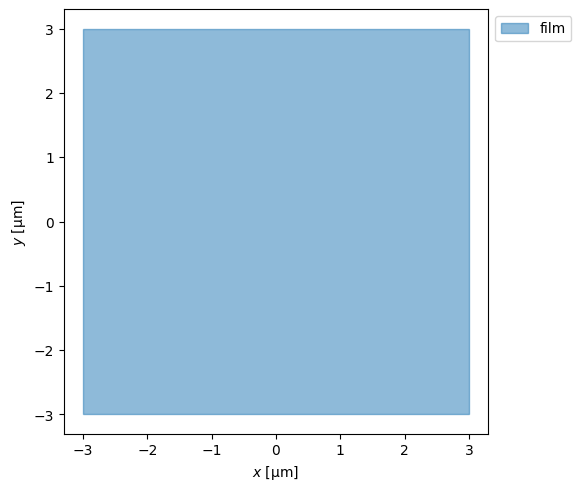

In [20]:
# Make Layer
length_units = 'um'

# Material parameters
xi = 1/3
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 6
total_length = 6

# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

#film = (tdgl.Polygon("film", points=circle(radius=total_width/2)).resample(401).buffer(0))

device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    length_units=length_units,
)

fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 4733/4733 [00:01<00:00, 2542.08it/s]


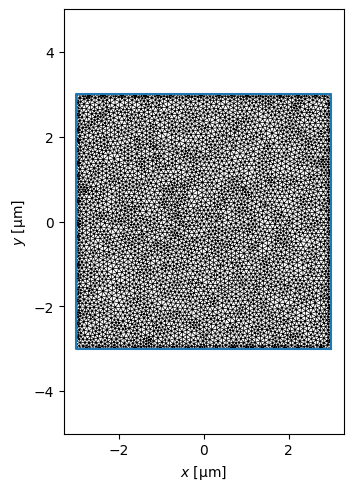

In [21]:
# Finite Volume Method
device.make_mesh(max_edge_length=xi / 2, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)
device.mesh_stats()

In [22]:
#funtions for external fields
def time_factor(x, y, z, *, t, setpoints):
    if t < setpoints[0, 0]:
        return setpoints[0, 1]
    elif t >= setpoints[-1, 0]:
        return setpoints[-1, 1]
    else:
        for i in range(len(setpoints)):
            ti, Bi = setpoints[i]
            tf, Bf = setpoints[i+1]
            Bi, Bf = float(Bi), float(Bf)
            if ti <= t < tf:
                return Bi + (Bf-Bi)*(t-ti)/(tf-ti)

def plot_time_factor(setpoints, field_unit):
    ti = setpoints[0, 0]
    tf = setpoints[-1, 0]
    T = np.linspace(ti, tf, max(100, 5*len(setpoints)))
    B = np.zeros_like(T)
    for i in range(len(T)):
        t = T[i]
        B[i] = time_factor(0, 0, 0, t=t, setpoints=setpoints)
    plt.plot(T, B)
    plt.ylabel('B/{unit}'.format(unit=field_unit))
    plt.xlabel('Time/s')
    plt.show()

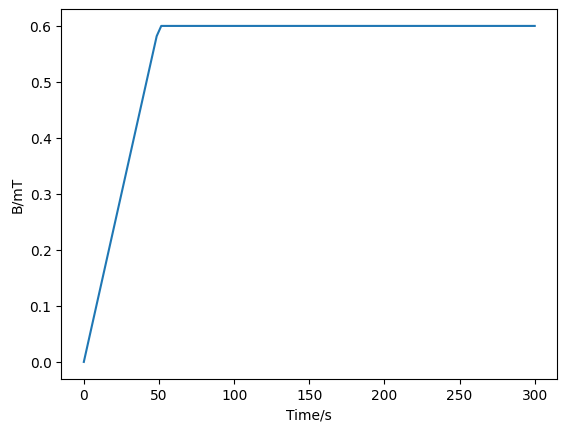

Output file already exists. Renaming to solutions/0821\circle_300-1.h5.
Simulating: 100%|█████████▉| 600/600 [01:37<00:00,  6.13tau/s ]


In [23]:
#External Field and Simualtion options
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    solve_time=600,
    output_file=os.path.join('solutions/0821', "circle_300.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)

from tdgl.sources import ConstantField

#Setpoints for External fields, should be like np.array([[t1, B1], ..., [tN, BN]]), with shape N*2
setpoints_pos = np.array([[0, 50, 300],
                      [0, 0.6, 0.6]])
setpoints = setpoints_pos.T
plot_time_factor(setpoints=setpoints, field_unit=options.field_units)

t_dependence = tdgl.Parameter(time_factor, setpoints=setpoints, time_dependent=True)
applied_vector_potential = ConstantField(1.0, field_units=options.field_units, length_units=device.length_units) * t_dependence

#Tune the temperature
def disorder_epsilon(r, *, t):
    if t < 300:
        return 0
    elif t >= 300:
        return 1

#seed to start with
'''
seed_solution = tdgl.Solution.from_hdf5(r'solutions\0816\seed_300.h5')
device = seed_solution.device
'''

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
    #disorder_epsilon=disorder_epsilon,
    #seed_solution=seed_solution,
)

Time: 0.0s  Field: 0.00mT


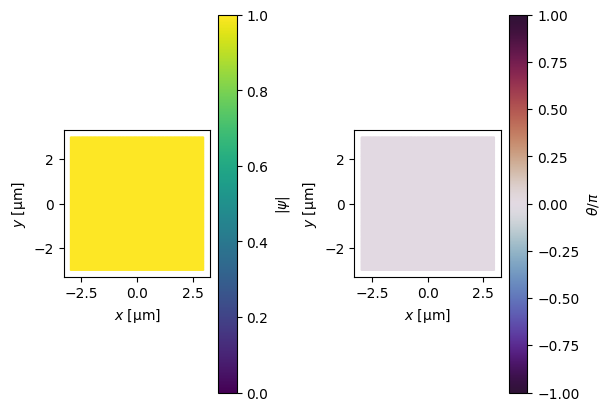

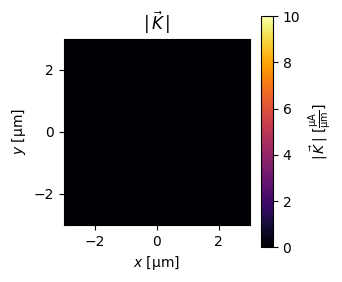

Time: 50.0s  Field: 0.60mT


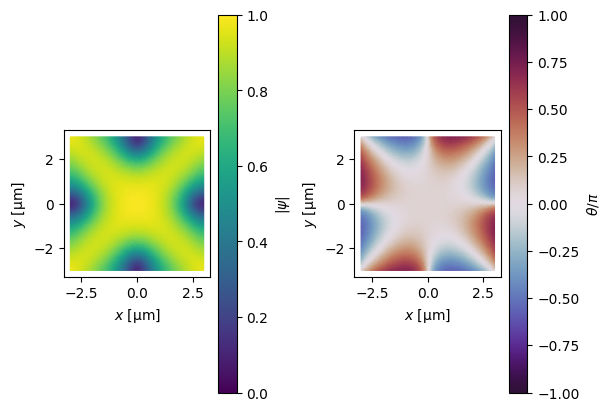

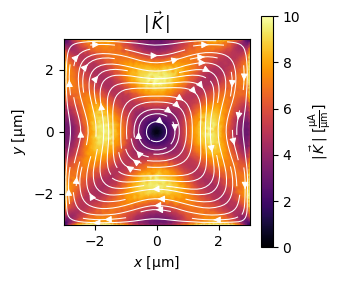

Time: 99.6s  Field: 0.60mT


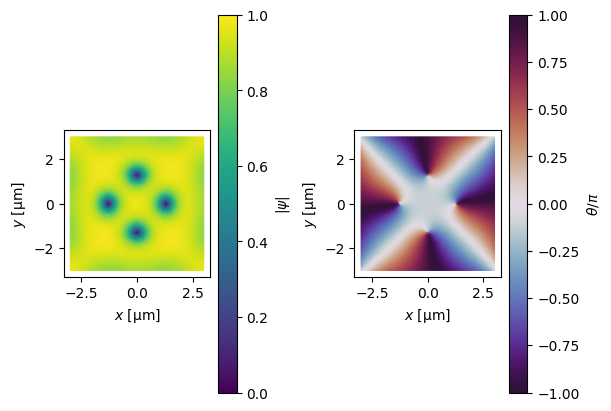

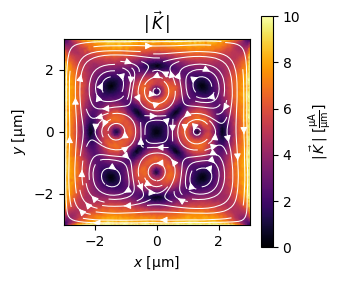

Time: 149.1s  Field: 0.60mT


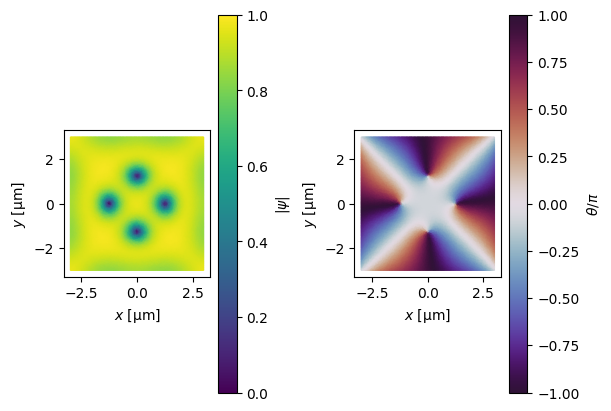

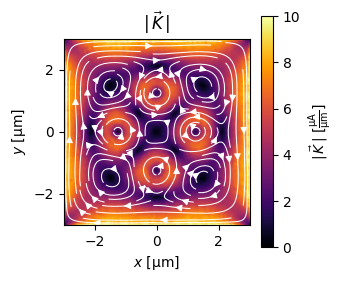

Time: 200.5s  Field: 0.60mT


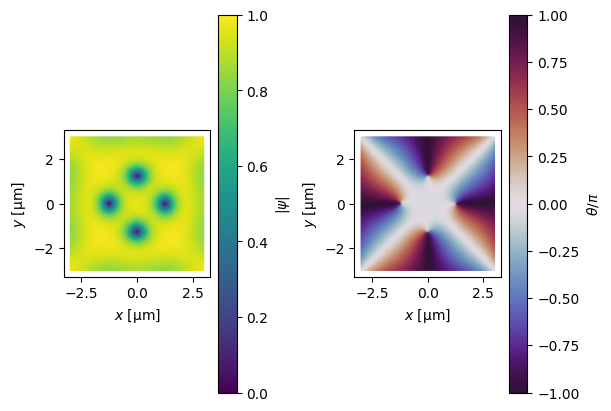

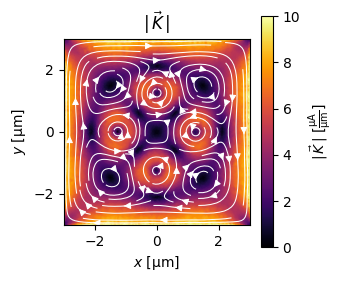

Time: 249.7s  Field: 0.60mT


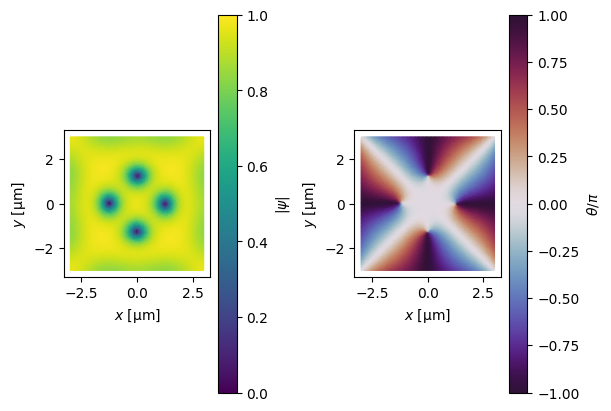

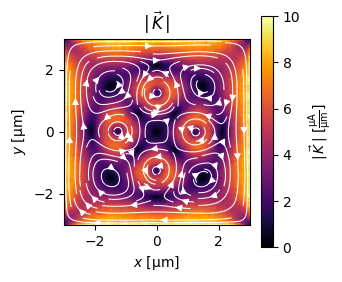

Time: 301.1s  Field: 0.60mT


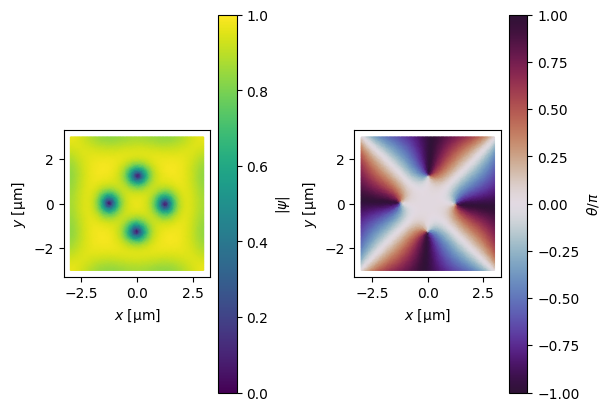

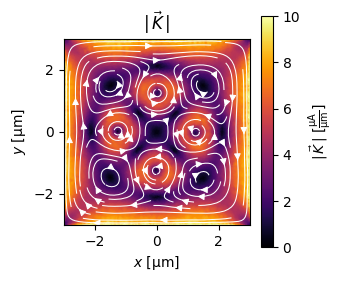

In [24]:
#Plot order parameter and current at certain time
def plot_simulations_of_times(solution, setpoints):
    '''
    Plot the order parameter and current at the time that is closest to the given time points.
    '''
    for time in setpoints:

        step = solution.closest_solve_step(time)
        exact_time = solution.times[step]
        solution.load_tdgl_data(step)

        A = solution.applied_vector_potential(np.array([-1, 1]), np.array([-1, 1]), np.array([0, 0]), t=exact_time)
        Bz = A[0, 0] - A[1, 0]

        print('Time: {exact_time:.1f}s  Field: {field:.2f}{unit}'.format(exact_time = solution.times[step], field = Bz, unit=solution.field_units))
        fig, axes = solution.plot_order_parameter(figsize=(6, 4))
        solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10, figsize = (3,3))

        plt.show()

samples = range(0, 301, 50)
#samples = [0, 5, 10, 15, 100]

plot_simulations_of_times(zero_current_solution, samples)

In [22]:
# Make Video
zero_field_video = make_video_from_solution(
        zero_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
display(zero_field_video)